# 머신 러닝 교과서 - 파이토치편

<table align="left"><tr><td>
<a href="https://colab.research.google.com/github/rickiepark/ml-with-pytorch/blob/main/ch05/ch05.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="코랩에서 실행하기"/></a>
</td></tr></table>

## 패키지 버전 체크

check_packages.py 스크립트에서 로드하기 위해 폴더를 추가합니다:

In [1]:
import sys

# 코랩의 경우 깃허브 저장소로부터 python_environment_check.py를 다운로드 합니다.
if 'google.colab' in sys.modules:
    !wget https://raw.githubusercontent.com/rickiepark/ml-with-pytorch/main/python_environment_check.py
else:
    sys.path.insert(0, '..')

--2023-10-07 06:37:13--  https://raw.githubusercontent.com/rickiepark/ml-with-pytorch/main/python_environment_check.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1629 (1.6K) [text/plain]
Saving to: ‘python_environment_check.py.1’

python_environment_ 100%[===================>]   1.59K  --.-KB/s    in 0s      

2023-10-07 06:37:14 (10.5 MB/s) - ‘python_environment_check.py.1’ saved [1629/1629]



권장 패키지 버전을 확인하세요:

In [2]:
from python_environment_check import check_packages


d = {
    'numpy': '1.21.2',
    'matplotlib': '3.4.3',
    'sklearn': '1.0',
    'pandas': '1.3.2'
}
check_packages(d)

[OK] Your Python version is 3.10.12 (main, Jun 11 2023, 05:26:28) [GCC 11.4.0]
[OK] numpy 1.23.5
[OK] matplotlib 3.7.1
[OK] sklearn 1.2.2
[OK] pandas 1.5.3


# 5장 - 차원 축소를 사용한 데이터 압축

### 목차

- 주성분 분석을 통한 비지도 차원 축소
  - 주성분 분석의 주요 단계
  - 주성분 추출 단계
  - 총분산과 설명된 분산
  - 특성 변환
  - 사이킷런의 주성분 분석
  - 특성 기여도 평가하기
- 선형 판별 분석을 통한 지도 방식의 데이터 압축
  - 주성분 분석 vs 선형 판별 분석
  - 선형 판별 분석의 내부 동작 방식
  - 산포 행렬 계산
  - 새로운 특성 부분 공간을 위해 선형 판별 벡터 선택
  - 새로운 특성 공간으로 샘플 투영
  - 사이킷런의 LDA
- 비선형 차원 축소와 시각화
  - 비선형 차원 축소를 고려하는 이유는 무엇인가요?
  - t-SNE를 사용한 데이터 시각화
- 요약

In [3]:
from IPython.display import Image
%matplotlib inline

# 주성분 분석을 통한 비지도 차원 축소


## 주성분 분석의 주요 단계


In [4]:
Image(url='https://raw.githubusercontent.com/rickiepark/ml-with-pytorch/main/ch05/figures/05_01.png', width=400)

## 주성분 추출 단계


In [5]:
import pandas as pd

df_wine = pd.read_csv('https://archive.ics.uci.edu/ml/'
                      'machine-learning-databases/wine/wine.data',
                      header=None)

# UCI 머신 러닝 저장소에서 Wine 데이터셋을 다운로드할 수 없을 때
# 다음 주석을 해제하고 로컬 경로에서 데이터셋을 적재하세요:

# df_wine = pd.read_csv('wine.data', header=None)

df_wine.columns = ['Class label', 'Alcohol', 'Malic acid', 'Ash',
                   'Alcalinity of ash', 'Magnesium', 'Total phenols',
                   'Flavanoids', 'Nonflavanoid phenols', 'Proanthocyanins',
                   'Color intensity', 'Hue',
                   'OD280/OD315 of diluted wines', 'Proline']

df_wine.head()

,Class label,Alcohol,Malic acid,Ash,Alcalinity of ash,Magnesium,Total phenols,Flavanoids,Nonflavanoid phenols,Proanthocyanins,Color intensity,Hue,OD280/OD315 of diluted wines,Proline
0,1,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065
1,1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050
2,1,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185
3,1,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480
4,1,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735


70%는 훈련 세트로 30%는 테스트 세트로 나눕니다.

In [6]:
from sklearn.model_selection import train_test_split

X, y = df_wine.iloc[:, 1:].values, df_wine.iloc[:, 0].values

X_train, X_test, y_train, y_test = \
    train_test_split(X, y, test_size=0.3,
                     stratify=y,
                     random_state=0)

데이터를 표준화합니다.

In [7]:
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
X_train_std = sc.fit_transform(X_train)
X_test_std = sc.transform(X_test)

---

**노트**

`X_test_std = sc.fit_transform(X_test)` 대신에 `X_test_std = sc.transform(X_test)`를 사용했습니다. 이 경우에 테스트 데이터셋의 평균과 표준편차가 훈련 데이터셋과 매우 비슷하기 때문에 큰 차이가 없습니다. 하지만 3장에서 보았듯이 데이터를 변환할 때 훈련 데이터셋에서 학습한 파라미터를 재사용하는 것이 올바른 방법입니다. 테스트 데이터셋은 "새로운 본 적 없는" 데이터를 의미하기 때문입니다.

초기에 `fit_transform(X_test)`를 사용했는데 이것은 모델 훈련에서 얻은 파라미터를 재사용하여 새로운 데이터를 표준화하지 않는 일반적인 실수입니다. 왜 이것이 문제가 되는지 간단한 예를 살펴 보겠습니다.

훈련 데이터셋에 1개의 특성("길이")을 가진 샘플 3개가 들어 있다고 가정해 보죠:

- train_1: 10 cm -> class_2
- train_2: 20 cm -> class_2
- train_3: 30 cm -> class_1

mean: 20, std.: 8.2

표준화를 한 후에 변환된 특성 값은 다음과 같습니다:

- train_std_1: -1.22 -> class_2
- train_std_2: 0 -> class_2
- train_std_3: 1.22 -> class_1

그다음 표준화된 길이가 0.6보다 작은 샘플을 class_2로 분류한다고 가정해 보죠(그 외에는 class_1). 지금까지는 좋습니다. 이제 레이블이 없는 3개의 포인트를 분류한다고 가정해 보죠:

- new_4: 5 cm -> class ?
- new_5: 6 cm -> class ?
- new_6: 7 cm -> class ?

훈련 데이터셋에 있는 표준화되기 전의 "길이" 값과 비교해 보면 직관적으로 이 샘플들은 class_2로 보입니다. 하지만 훈련 데이터셋에서 했던 것처럼 평균과 표준편차를 다시 계산하여 표준화하면 아마도 분류기가 샘플 4번과 5번만 class_2로 분류할 것입니다.

- new_std_4: -1.22 -> class 2
- new_std_5: 0 -> class 2
- new_std_6: 1.22 -> class 1

하지만 훈련 데이터셋의 표준화에 사용했던 파라미터를 사용하면 다음과 같은 값을 얻습니다:

- example5: -1.84 -> class 2
- example6: -1.71 -> class 2
- example7: -1.59 -> class 2

5 cm, 6 cm, 7 cm는 훈련 데이터셋에 있는 어떤 것보다도 작습니다. 따라서 훈련 데이터셋을 표준화한 값보다도 훨씬 작은 값으로 표준화되어야 합니다.

---

공분산 행렬의 고윳값 분해

In [8]:
import numpy as np
cov_mat = np.cov(X_train_std.T)
eigen_vals, eigen_vecs = np.linalg.eig(cov_mat)

print('\n고윳값 \n', eigen_vals)


고윳값 
 [4.84274532 2.41602459 1.54845825 0.96120438 0.84166161 0.6620634
 0.51828472 0.34650377 0.3131368  0.10754642 0.21357215 0.15362835
 0.1808613 ]


**노트**:

위에서 [`numpy.linalg.eig`](http://docs.scipy.org/doc/numpy/reference/generated/numpy.linalg.eig.html) 함수를 사용해 대칭 공분산 행렬을 고윳값과 고유벡터로 분해했습니다.

<pre>>>> eigen_vals, eigen_vecs = np.linalg.eig(cov_mat)</pre>

이것이 잘못된 것은 아니지만 최적은 아닙니다. [에르미트(Hermetian) 행렬](https://en.wikipedia.org/wiki/Hermitian_matrix)를 위해서 설계된 [`numpy.linalg.eigh`](http://docs.scipy.org/doc/numpy/reference/generated/numpy.linalg.eigh.html)를 사용하는 것이 더 좋습니다. 이 함수는 항상 실수 고윳값을 반환합니다. 수치적으로 약간 덜 안정적인 `np.linalg.eig`는 비대칭 정방행렬을 분해할 수 있지만 어떤 경우에 복소수 고윳값을 반환할 수 있습니다.

## 총분산과 설명된 분산


In [9]:
tot = sum(eigen_vals)
var_exp = [(i / tot) for i in sorted(eigen_vals, reverse=True)]
cum_var_exp = np.cumsum(var_exp)

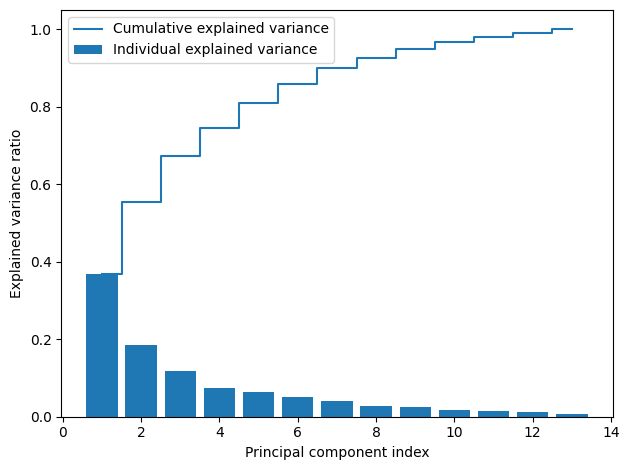

In [10]:
import matplotlib.pyplot as plt


plt.bar(range(1, 14), var_exp, align='center',
        label='Individual explained variance')
plt.step(range(1, 14), cum_var_exp, where='mid',
         label='Cumulative explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal component index')
plt.legend(loc='best')
plt.tight_layout()
# plt.savefig('figures/05_02.png', dpi=300)
plt.show()

## 특성 변환


In [11]:
# (고윳값, 고유벡터) 튜플의 리스트를 만듭니다
eigen_pairs = [(np.abs(eigen_vals[i]), eigen_vecs[:, i])
               for i in range(len(eigen_vals))]

# 높은 값에서 낮은 값으로 (고윳값, 고유벡터) 튜플을 정렬합니다
eigen_pairs.sort(key=lambda k: k[0], reverse=True)

In [12]:
w = np.hstack((eigen_pairs[0][1][:, np.newaxis],
               eigen_pairs[1][1][:, np.newaxis]))
print('투영 행렬 W:\n', w)

투영 행렬 W:
 [[-0.13724218  0.50303478]
 [ 0.24724326  0.16487119]
 [-0.02545159  0.24456476]
 [ 0.20694508 -0.11352904]
 [-0.15436582  0.28974518]
 [-0.39376952  0.05080104]
 [-0.41735106 -0.02287338]
 [ 0.30572896  0.09048885]
 [-0.30668347  0.00835233]
 [ 0.07554066  0.54977581]
 [-0.32613263 -0.20716433]
 [-0.36861022 -0.24902536]
 [-0.29669651  0.38022942]]


**노트:**

사용하는 Numpy와 LAPACK 버전에 따라 행렬 W의 부호가 바뀔 수 있습니다. 이는 문제가 아닙니다. $v$가 행렬 $\Sigma$의 고유벡터라면 다음을 얻을 수 있습니다.

$$\Sigma v = \lambda v,$$

여기에서 $\lambda$는 고윳값입니다.

$$\Sigma \cdot (-v) = -\Sigma v = -\lambda v = \lambda \cdot (-v).$$이기 때문에 $-v$도 동일한 고윳값을 가진 고유벡터입니다.

In [13]:
X_train_std[0].dot(w)

array([2.38299011, 0.45458499])

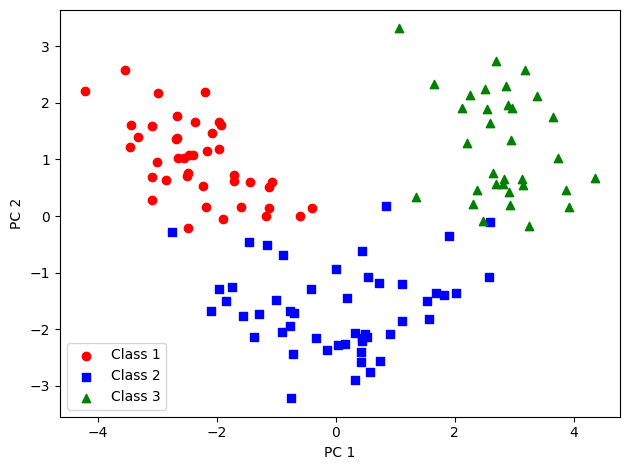

In [14]:
X_train_pca = X_train_std.dot(w)
colors = ['r', 'b', 'g']
markers = ['o', 's', '^']

for l, c, m in zip(np.unique(y_train), colors, markers):
    plt.scatter(X_train_pca[y_train == l, 0],
                X_train_pca[y_train == l, 1],
                c=c, label=f'Class {l}', marker=m)

plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.legend(loc='lower left')
plt.tight_layout()
# plt.savefig('figures/05_03.png', dpi=300)
plt.show()

## 사이킷런의 주성분 분석


**노트**

이어지는 네 개의 셀은 책에 없는 내용입니다. 사이킷런에서 앞의 PCA 구현 결과를 재현하기 위해 추가했습니다:

In [15]:
from sklearn.decomposition import PCA

pca = PCA()
X_train_pca = pca.fit_transform(X_train_std)
pca.explained_variance_ratio_

array([0.36951469, 0.18434927, 0.11815159, 0.07334252, 0.06422108,
       0.05051724, 0.03954654, 0.02643918, 0.02389319, 0.01629614,
       0.01380021, 0.01172226, 0.00820609])

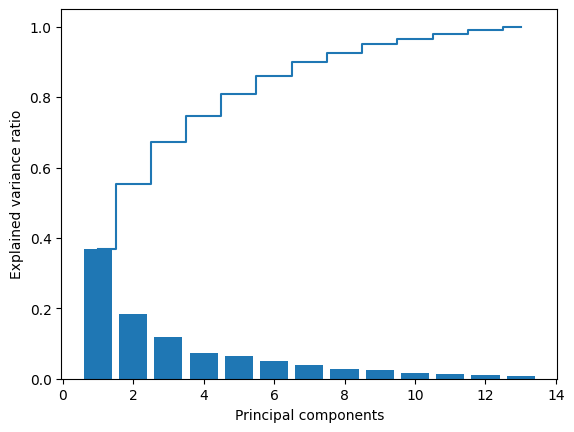

In [16]:
plt.bar(range(1, 14), pca.explained_variance_ratio_, align='center')
plt.step(range(1, 14), np.cumsum(pca.explained_variance_ratio_), where='mid')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal components')

plt.show()

In [17]:
pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train_std)
X_test_pca = pca.transform(X_test_std)

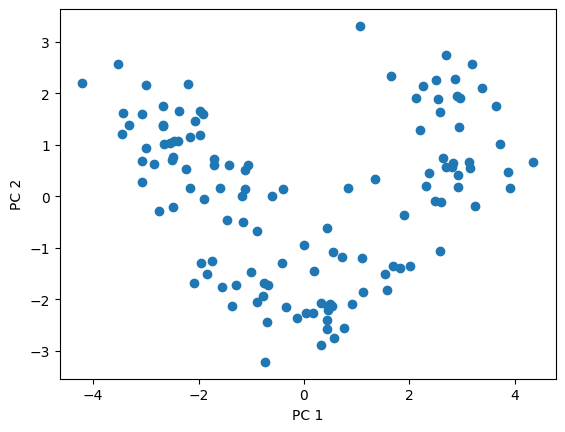

In [18]:
plt.scatter(X_train_pca[:, 0], X_train_pca[:, 1])
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.show()

In [19]:
from matplotlib.colors import ListedColormap

def plot_decision_regions(X, y, classifier, test_idx=None, resolution=0.02):

    # 마커와 컬러맵을 준비합니다
    markers = ('o', 's', '^', 'v', '<')
    colors = ('red', 'blue', 'lightgreen', 'gray', 'cyan')
    cmap = ListedColormap(colors[:len(np.unique(y))])

    # 결정 경계를 그립니다
    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
                           np.arange(x2_min, x2_max, resolution))
    lab = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    lab = lab.reshape(xx1.shape)
    plt.contourf(xx1, xx2, lab, alpha=0.3, cmap=cmap)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())

    # 클래스별로 샘플을 그립니다
    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(x=X[y == cl, 0],
                    y=X[y == cl, 1],
                    alpha=0.8,
                    c=colors[idx],
                    marker=markers[idx],
                    label=f'Class {cl}',
                    edgecolor='black')

처음 두 개의 주성분을 사용하여 로지스틱 회귀 분류기를 훈련합니다.

In [20]:
from sklearn.linear_model import LogisticRegression

pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train_std)
X_test_pca = pca.transform(X_test_std)

lr = LogisticRegression(multi_class='ovr', random_state=1, solver='lbfgs')
lr = lr.fit(X_train_pca, y_train)

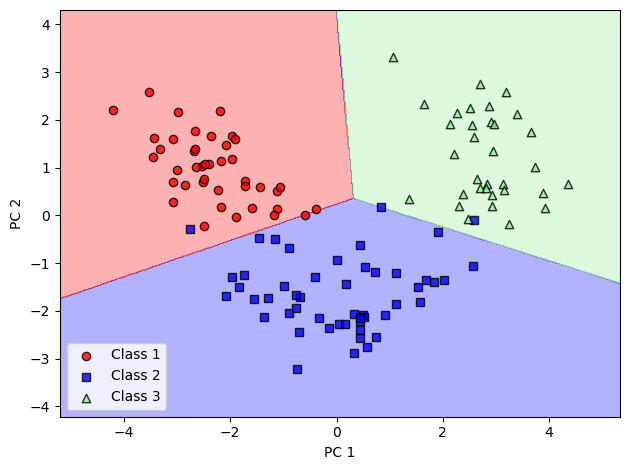

In [21]:
plot_decision_regions(X_train_pca, y_train, classifier=lr)
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.legend(loc='lower left')
plt.tight_layout()
# plt.savefig('figures/05_04.png', dpi=300)
plt.show()

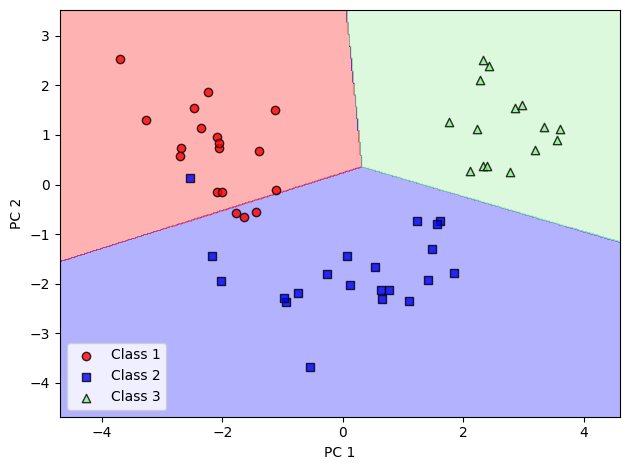

In [22]:
plot_decision_regions(X_test_pca, y_test, classifier=lr)
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.legend(loc='lower left')
plt.tight_layout()
# plt.savefig('figures/05_05.png', dpi=300)
plt.show()

In [23]:
pca = PCA(n_components=None)
X_train_pca = pca.fit_transform(X_train_std)
pca.explained_variance_ratio_

array([0.36951469, 0.18434927, 0.11815159, 0.07334252, 0.06422108,
       0.05051724, 0.03954654, 0.02643918, 0.02389319, 0.01629614,
       0.01380021, 0.01172226, 0.00820609])

<역자 노트>

---

In [24]:
pca = PCA(n_components=0.95)
pca.fit(X_train_std)
print('주성분 개수:', pca.n_components_)
print('설명된 분산 비율:', np.sum(pca.explained_variance_ratio_))

주성분 개수: 10
설명된 분산 비율: 0.966271440655874


In [25]:
pca = PCA(n_components='mle')
pca.fit(X_train_std)
print('주성분 개수:', pca.n_components_)
print('설명된 분산 비율:', np.sum(pca.explained_variance_ratio_))

주성분 개수: 9
설명된 분산 비율: 0.949975302918623


In [26]:
from sklearn.decomposition import IncrementalPCA

ipca = IncrementalPCA(n_components=9)
for batch in range(len(X_train_std)//25+1):
    X_batch = X_train_std[batch*25:(batch+1)*25]
    ipca.partial_fit(X_batch)

print('주성분 개수:', ipca.n_components_)
print('설명된 분산 비율:', np.sum(ipca.explained_variance_ratio_))

주성분 개수: 9
설명된 분산 비율: 0.9478392700446645


---

## 특성 기여도 평가하기


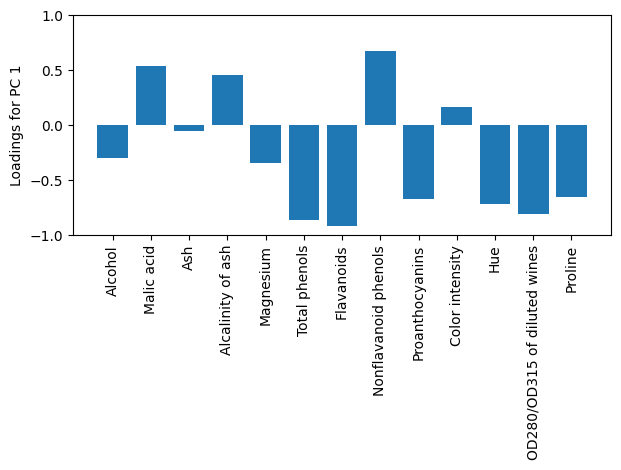

In [27]:
loadings = eigen_vecs * np.sqrt(eigen_vals)

fig, ax = plt.subplots()

ax.bar(range(13), loadings[:, 0], align='center')
ax.set_ylabel('Loadings for PC 1')
ax.set_xticks(range(13))
ax.set_xticklabels(df_wine.columns[1:], rotation=90)

plt.ylim([-1, 1])
plt.tight_layout()
# plt.savefig('figures/05_05_02.png', dpi=300)
plt.show()

In [28]:
loadings[:, 0]

array([-0.3020184 ,  0.54408942, -0.05600938,  0.45540829, -0.33970111,
       -0.8665386 , -0.9184327 ,  0.67279444, -0.67489496,  0.16623657,
       -0.71769524, -0.81117245, -0.65291742])

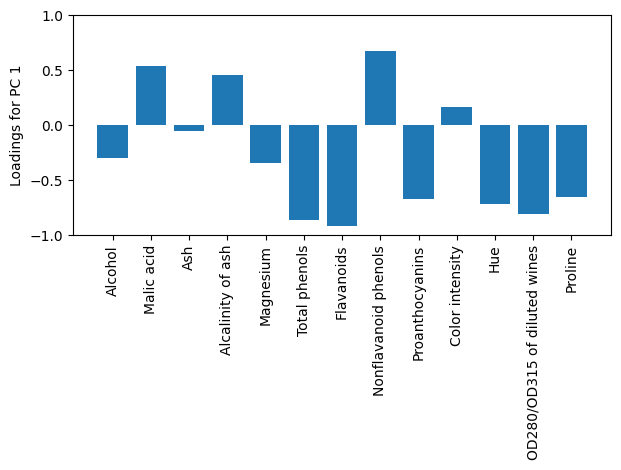

In [29]:
sklearn_loadings = pca.components_.T * np.sqrt(pca.explained_variance_)

fig, ax = plt.subplots()

ax.bar(range(13), sklearn_loadings[:, 0], align='center')
ax.set_ylabel('Loadings for PC 1')
ax.set_xticks(range(13))
ax.set_xticklabels(df_wine.columns[1:], rotation=90)

plt.ylim([-1, 1])
plt.tight_layout()
# plt.savefig('figures/05_05_03.png', dpi=300)
plt.show()

# 선형 판별 분석을 통한 지도 방식의 데이터 압축


## 주성분 분석 vs 선형 판별 분석


In [30]:
Image(url='https://raw.githubusercontent.com/rickiepark/ml-with-pytorch/main/ch05/figures/05_06.png', width=400)

## 선형 판별 분석의 내부 동작 방식


## 산포 행렬 계산


각 클래스에 대한 평균 벡터를 계산합니다:

In [31]:
np.set_printoptions(precision=4)

mean_vecs = []
for label in range(1, 4):
    mean_vecs.append(np.mean(X_train_std[y_train == label], axis=0))
    print(f'MV {label}: {mean_vecs[label - 1]}\n')

MV 1: [ 0.9066 -0.3497  0.3201 -0.7189  0.5056  0.8807  0.9589 -0.5516  0.5416
  0.2338  0.5897  0.6563  1.2075]

MV 2: [-0.8749 -0.2848 -0.3735  0.3157 -0.3848 -0.0433  0.0635 -0.0946  0.0703
 -0.8286  0.3144  0.3608 -0.7253]

MV 3: [ 0.1992  0.866   0.1682  0.4148 -0.0451 -1.0286 -1.2876  0.8287 -0.7795
  0.9649 -1.209  -1.3622 -0.4013]



클래스 내 산포 행렬을 계산합니다:

In [32]:
d = 13 # 특성의 수
S_W = np.zeros((d, d))
for label, mv in zip(range(1, 4), mean_vecs):
    class_scatter = np.zeros((d, d))  # 각 클래스에 대한 산포 행렬
    for row in X_train_std[y_train == label]:
        row, mv = row.reshape(d, 1), mv.reshape(d, 1)  # 열 벡터를 만듭니다
        class_scatter += (row - mv).dot((row - mv).T)
    S_W += class_scatter                          #클래스 산포 행렬을 더합니다

print('클래스 내의 산포 행렬: '
      f'{S_W.shape[0]}x{S_W.shape[1]}')

클래스 내의 산포 행렬: 13x13


클래스가 균일하게 분포되어 있지 않기 때문에 공분산 행렬을 사용하는 것이 더 낫습니다:

In [33]:
print('클래스 레이블 분포:',
      np.bincount(y_train)[1:])

클래스 레이블 분포: [41 50 33]


In [34]:
d = 13  # 특성의 수
S_W = np.zeros((d, d))
for label, mv in zip(range(1, 4), mean_vecs):
    class_scatter = np.cov(X_train_std[y_train == label].T)
    S_W += class_scatter

print('스케일 조정된 클래스 내의 산포 행렬: '
      f'{S_W.shape[0]}x{S_W.shape[1]}')

스케일 조정된 클래스 내의 산포 행렬: 13x13


클래스 간 산포 행렬을 계산합니다:

In [35]:
mean_overall = np.mean(X_train_std, axis=0)
mean_overall = mean_overall.reshape(d, 1)  # 열 벡터로 만들기

d = 13  # number of features
S_B = np.zeros((d, d))

for i, mean_vec in enumerate(mean_vecs):
    n = X_train_std[y_train == i + 1, :].shape[0]
    mean_vec = mean_vec.reshape(d, 1)  # 열 벡터로 만들기
    S_B += n * (mean_vec - mean_overall).dot((mean_vec - mean_overall).T)

print('클래스 간의 산포 행렬: '
      f'{S_B.shape[0]}x{S_B.shape[1]}')

클래스 간의 산포 행렬: 13x13


## 새로운 특성 부분 공간을 위해 선형 판별 벡터 선택


행렬 $\boldsymbol S_W^{-1}\boldsymbol S_B$의 일반적인 고윳값 분해 문제를 풉니다:

In [36]:
eigen_vals, eigen_vecs = np.linalg.eig(np.linalg.inv(S_W).dot(S_B))

고윳값의 역순으로 고유 벡터를 정렬합니다

In [37]:
# (고윳값, 고유벡터) 튜플의 리스트를 만듭니다.
eigen_pairs = [(np.abs(eigen_vals[i]), eigen_vecs[:, i])
               for i in range(len(eigen_vals))]

# (고윳값, 고유벡터) 튜플을 큰 값에서 작은 값 순서대로 정렬합니다.
eigen_pairs = sorted(eigen_pairs, key=lambda k: k[0], reverse=True)

# 고윳값의 역순으로 올바르게 정렬되었는지 확인합니다.
print('내림차순의 고윳값:\n')
for eigen_val in eigen_pairs:
    print(eigen_val[0])

내림차순의 고윳값:

349.61780890599397
172.7615221897938
3.342838214841367e-14
2.842170943040401e-14
2.5545786180111422e-14
1.7533939180734234e-14
1.7533939180734234e-14
1.6579193995960903e-14
1.6579193995960903e-14
8.242524002707225e-15
8.242524002707225e-15
6.36835506006027e-15
2.974634375545734e-15


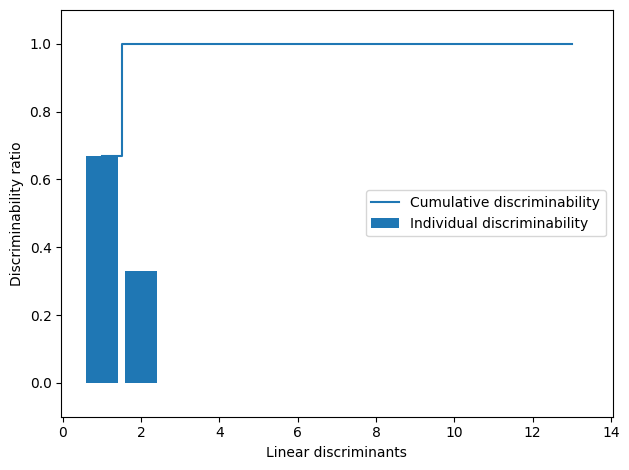

In [38]:
tot = sum(eigen_vals.real)
discr = [(i / tot) for i in sorted(eigen_vals.real, reverse=True)]
cum_discr = np.cumsum(discr)

plt.bar(range(1, 14), discr, align='center',
        label='Individual discriminability')
plt.step(range(1, 14), cum_discr, where='mid',
         label='Cumulative discriminability')
plt.ylabel('Discriminability ratio')
plt.xlabel('Linear discriminants')
plt.ylim([-0.1, 1.1])
plt.legend(loc='best')
plt.tight_layout()
#plt.savefig('figures/05_07.png', dpi=300)
plt.show()

In [39]:
w = np.hstack((eigen_pairs[0][1][:, np.newaxis].real,
              eigen_pairs[1][1][:, np.newaxis].real))
print('변환 행렬 W:\n', w)

변환 행렬 W:
 [[-0.1481 -0.4092]
 [ 0.0908 -0.1577]
 [-0.0168 -0.3537]
 [ 0.1484  0.3223]
 [-0.0163 -0.0817]
 [ 0.1913  0.0842]
 [-0.7338  0.2823]
 [-0.075  -0.0102]
 [ 0.0018  0.0907]
 [ 0.294  -0.2152]
 [-0.0328  0.2747]
 [-0.3547 -0.0124]
 [-0.3915 -0.5958]]


## 새로운 특성 공간으로 샘플 투영


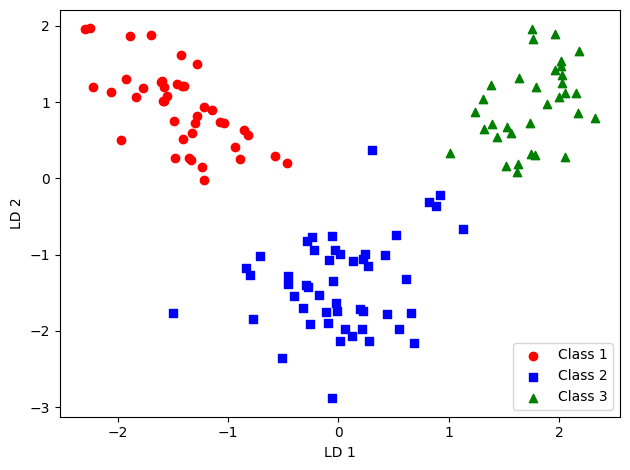

In [40]:
X_train_lda = X_train_std.dot(w)
colors = ['r', 'b', 'g']
markers = ['o', 's', '^']

for l, c, m in zip(np.unique(y_train), colors, markers):
    plt.scatter(X_train_lda[y_train == l, 0],
                X_train_lda[y_train == l, 1] * (-1),
                c=c, label=f'Class {l}', marker=m)

plt.xlabel('LD 1')
plt.ylabel('LD 2')
plt.legend(loc='lower right')
plt.tight_layout()
# plt.savefig('figures/05_08.png', dpi=300)
plt.show()

## 사이킷런의 LDA


In [41]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

lda = LDA(n_components=2)
X_train_lda = lda.fit_transform(X_train_std, y_train)

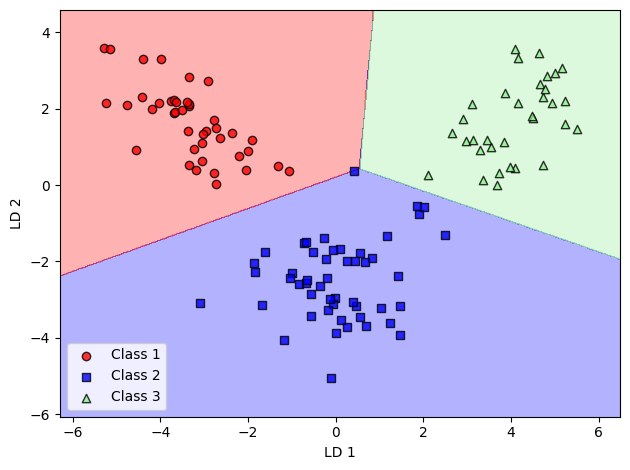

In [42]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(multi_class='ovr', random_state=1, solver='lbfgs')
lr = lr.fit(X_train_lda, y_train)

plot_decision_regions(X_train_lda, y_train, classifier=lr)
plt.xlabel('LD 1')
plt.ylabel('LD 2')
plt.legend(loc='lower left')
plt.tight_layout()
# plt.savefig('figures/05_09.png', dpi=300)
plt.show()

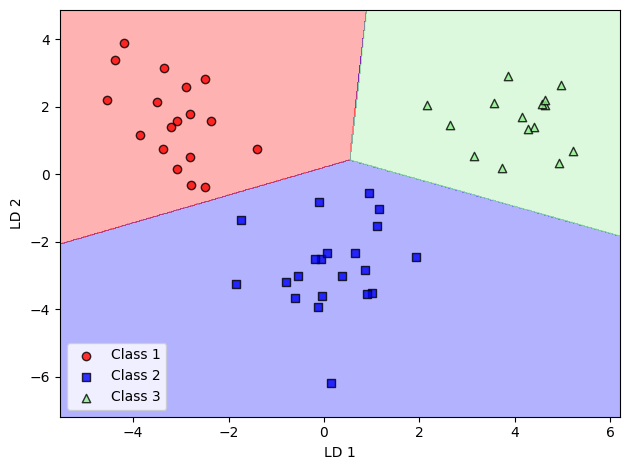

In [43]:
X_test_lda = lda.transform(X_test_std)

plot_decision_regions(X_test_lda, y_test, classifier=lr)
plt.xlabel('LD 1')
plt.ylabel('LD 2')
plt.legend(loc='lower left')
plt.tight_layout()
# plt.savefig('figures/05_10.png', dpi=300)
plt.show()

<역자 노트>

---

In [44]:
y_uniq, y_count = np.unique(y_train, return_counts=True)
priors = y_count / X_train_std.shape[0]
priors

array([0.3306, 0.4032, 0.2661])

In [45]:
s_w = np.zeros((X_train_std.shape[1], X_train_std.shape[1]))
for i, label in enumerate(y_uniq):
    # 1/(n-1)이 아니라 1/n로 나눈 공분산 행렬을 얻기 위해 bias=True로 지정합니다.
    s_w += priors[i] * np.cov(X_train_std[y_train == label].T, bias=True)

In [46]:
s_b = np.zeros((X_train_std.shape[1], X_train_std.shape[1]))
for i, mean_vec in enumerate(mean_vecs):
    n = X_train_std[y_train == i + 1].shape[0]
    mean_vec = mean_vec.reshape(-1, 1)
    s_b += priors[i] * (mean_vec - mean_overall).dot((mean_vec - mean_overall).T)

In [47]:
import scipy
ei_val, ei_vec = scipy.linalg.eigh(s_b, s_w)
ei_vec = ei_vec[:, np.argsort(ei_val)[::-1]]

In [48]:
lda_eigen = LDA(solver='eigen')
lda_eigen.fit(X_train_std, y_train)

LinearDiscriminantAnalysis(solver='eigen')

In [49]:
# 클래스 내의 산포 행렬은 covariance_ 속성에 저장되어 있습니다.
np.allclose(s_w, lda_eigen.covariance_)

True

In [50]:
Sb = np.cov(X_train_std.T, bias=True) - lda_eigen.covariance_
np.allclose(Sb, s_b)

True

In [51]:
# 고유 벡터는 scalings_ 속성에 저장되어 있습니다.
np.allclose(lda_eigen.scalings_[:, :2], ei_vec[:, :2])

True

In [52]:
np.allclose(lda_eigen.transform(X_test_std), np.dot(X_test_std, ei_vec[:, :2]))

True

---

# 비선형 차원 축소와 시각화


### 비선형 차원 축소를 고려하는 이유는 무엇인가요?


In [53]:
Image(url='https://raw.githubusercontent.com/rickiepark/ml-with-pytorch/main/ch05/figures/05_11.png', width=500)

### t-SNE를 사용한 데이터 시각화


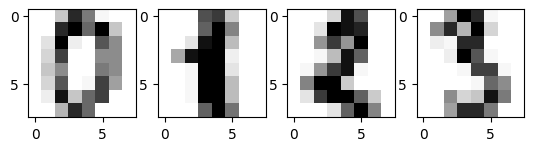

In [54]:
from sklearn.datasets import load_digits

digits = load_digits()

fig, ax = plt.subplots(1, 4)

for i in range(4):
    ax[i].imshow(digits.images[i], cmap='Greys')

# plt.savefig('figures/05_12.png', dpi=300)
plt.show()

In [55]:
digits.data.shape

(1797, 64)

In [56]:
y_digits = digits.target
X_digits = digits.data

In [57]:
from sklearn.manifold import TSNE


tsne = TSNE(n_components=2,
            init='pca',
            random_state=123)
X_digits_tsne = tsne.fit_transform(X_digits)

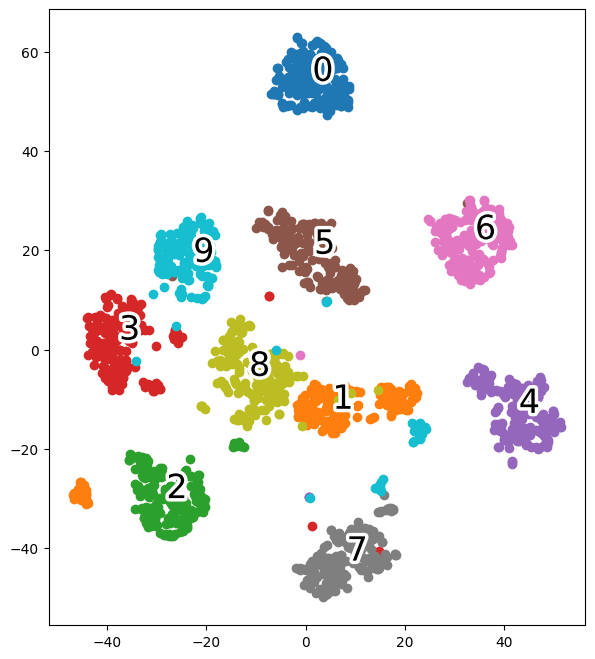

In [58]:
import matplotlib.patheffects as PathEffects


def plot_projection(x, colors):

    f = plt.figure(figsize=(8, 8))
    ax = plt.subplot(aspect='equal')
    for i in range(10):
        plt.scatter(x[colors == i, 0],
                    x[colors == i, 1])

    for i in range(10):

        xtext, ytext = np.median(x[colors == i, :], axis=0)
        txt = ax.text(xtext, ytext, str(i), fontsize=24)
        txt.set_path_effects([
            PathEffects.Stroke(linewidth=5, foreground="w"),
            PathEffects.Normal()])

plot_projection(X_digits_tsne, y_digits)
# plt.savefig('figures/05_13.png', dpi=300)
plt.show()

# 요약